In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor()
)

test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor()
)


Sets of pictures somewhat like the one below.

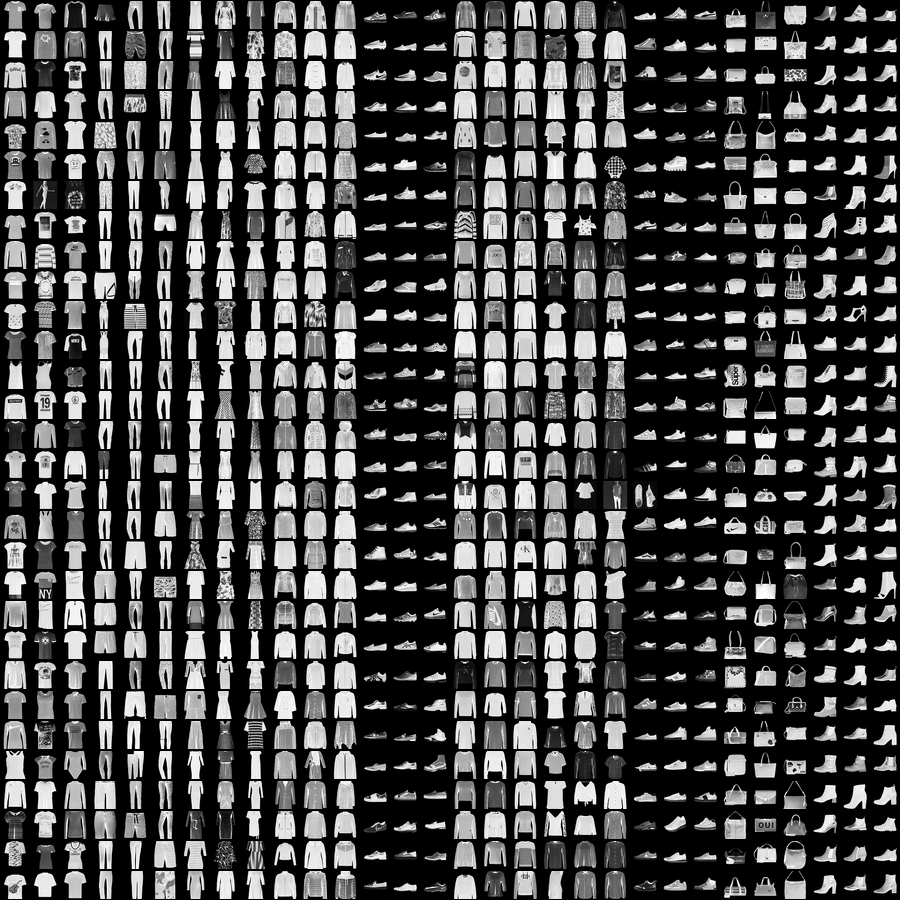

We pass the `Dataset` as an argument to `DataLoader`. This wraps an iterable over our dataset, and supports automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

In [2]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


Get cpu, gpu or mps resources

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


Define model
To define a neural network in PyTorch, we create a class that inherits from nn.Module. We define the layers of the network in the __init__ function and specify how data will pass through the network in the forward function. To accelerate operations in the neural network, we move it to the GPU or MPS if available.

In [4]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Model done, to train it we need a [loss function](https://pytorch.org/docs/stable/nn.html#loss-functions) and an [optimizer](https://pytorch.org/docs/stable/optim.html)

In [5]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and backpropagates the prediction error to adjust the model’s parameters.

In [6]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [7]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

The training process is conducted over several iterations (epochs). During each epoch, the model learns parameters to make better predictions. We print the model’s accuracy and loss at each epoch; we’d like to see the accuracy increase and the loss decrease with every epoch.

In [8]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.293142  [   64/60000]
loss: 2.288421  [ 6464/60000]
loss: 2.270314  [12864/60000]
loss: 2.253713  [19264/60000]
loss: 2.248505  [25664/60000]
loss: 2.208697  [32064/60000]
loss: 2.209832  [38464/60000]
loss: 2.180004  [44864/60000]
loss: 2.173395  [51264/60000]
loss: 2.125442  [57664/60000]
Test Error: 
 Accuracy: 51.4%, Avg loss: 2.127120 

Epoch 2
-------------------------------
loss: 2.144802  [   64/60000]
loss: 2.134244  [ 6464/60000]
loss: 2.073147  [12864/60000]
loss: 2.076661  [19264/60000]
loss: 2.027181  [25664/60000]
loss: 1.961460  [32064/60000]
loss: 1.983425  [38464/60000]
loss: 1.909392  [44864/60000]
loss: 1.920519  [51264/60000]
loss: 1.820137  [57664/60000]
Test Error: 
 Accuracy: 55.9%, Avg loss: 1.831713 

Epoch 3
-------------------------------
loss: 1.879266  [   64/60000]
loss: 1.843157  [ 6464/60000]
loss: 1.726123  [12864/60000]
loss: 1.755461  [19264/60000]
loss: 1.650816  [25664/60000]
loss: 1.604611  [32064/600

Read more about [Training your model](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html).

In [9]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


This model can now be used to make predictions.

In [10]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[8][0], test_data[9][1]
print(y)
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    print(pred[0].argmax(0))
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

7
tensor(7, device='cuda:0')
Predicted: "Sneaker", Actual: "Sneaker"
